<a href="https://colab.research.google.com/github/oknott14/ENG375_Creative_Proj/blob/main/LOTR_Names.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
from bs4 import BeautifulSoup as bs
from google.colab import drive
import re
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import IPython
!git clone 'https://github.com/oknott14/ENG375_Creative_Proj.git'

fatal: destination path 'ENG375_Creative_Proj' already exists and is not an empty directory.


#Setup
To begin we will scrape all of the names from The Lord of the Rings from a website. I have chosen http://lotrproject.com/. Scraping a website involves sifting through all of the html and only keeping what is relevant. Here are the first 5 html tags taken from the website. They reject your authentification when making requests through python's libraries, so we have stored the html in the file read above.

Within this HTML, we are looking for all \<div> tags with the element class. These store all of the information we will need about the characters. Using BeautifulSoup, a python library, this is quite easy.

In [27]:
html = bs(open('ENG375_Creative_Proj/LOTR_Family_Tree.rtf').read())
elements = html.find_all('div', 'element')
elements[0:5]

[<div class="Dunedain Man element" id="1" style="width:100px; top:5068px; left: 3332px;"><div class="position"></div><div class="livedin Rivendell MinasTirith"></div><div class="age ta foa"></div>Aragorn II</div>,
 <div class=" Half-elf element" id="2" style="width:100px; top:5068px; left: 3184px;"><div class="position"></div><div class="livedin Rivendell MinasTirith"></div><div class="age ta foa"></div>Arwen</div>,
 <div class=" Half-elf element" id="3" style="width:100px; top:1153px; left: 3110px;"><div class="position"></div><div class="livedin HavensofSirion Lindon Rivendell"></div><div class="age fa sa ta foa"></div>Elrond</div>,
 <div class=" Elf element" id="4" style="width:100px; top:1153px; left: 2970px;"><div class="livedin Eregion Lothlorien Rivendell"></div><div class="age ta"></div>Celebr\'edan</div>,
 <div class=" Half-elf element" id="5" style="width:100px; top:1213px; left: 2830px;"><div class="livedin Rivendell"></div><div class="age ta foa"></div>Elrohir</div>]

From here, we can access specific iformation for each character. Above, you can see that Aragorn's tag is accompanied by his Dunedain / Man race and some of the places that he has lived. This is what we will extract from the tags.

In [28]:
#Process names and families
elements = html.find_all('div', 'element')
data = []
alt = []
for elt in elements:
  name = re.sub(r"\\|\n|'|\dst|\dnd|\drd|\dth|\d", "", elt.text)
  if '?' in name:
    continue
  try:
    ethn, race, _ = elt.attrs['class']
  except:
    attr = elt.attrs['class'][:-1]
    if attr[0] == 'noncanon':
      _, ethn, race = attr
    elif attr[0] == 'House':
      _,_, ethn, race = attr
      ethn = f'House of {ethn}'
    elif attr[0] == '':
      ethn = None
      race = 'Man or Elf'
    elif attr[0] == 'Nazgul':
      ethn = 'Nazgul/Wraith'
      race = 'Man'
    elif attr[0] == 'Anomaly':
      continue
    else:
      fam, dist, race = attr
      ethn = f'{fam}-{dist}'
  ethn = None if ethn == "" else ethn

  lvin = elt.find('div','livedin')
  homes = None if lvin is None else lvin.attrs['class'][1:]
  data.append([name, ethn, race, homes])
data = np.array(data)
df = pd.DataFrame(data, columns=['Name','Ethnicity','Race', 'Homes'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


From the HTML, we took each character's name, their ethnicity (if provided), their race, and the places they have lived (if provided). Now that we have all our data, we can turn names into numebers.

In [29]:
df.head()

,Name,Ethnicity,Race,Homes
0,Aragorn II,Dunedain,Man,"[Rivendell, MinasTirith]"
1,Arwen,None,Half-elf,"[Rivendell, MinasTirith]"
2,Elrond,None,Half-elf,"[HavensofSirion, Lindon, Rivendell]"
3,Celebredan,None,Elf,"[Eregion, Lothlorien, Rivendell]"
4,Elrohir,None,Half-elf,[Rivendell]


#Short Example
Our strategy will be to take the letters of each name and map them to 26 dimensions. From here, we can compute the "distance" of any name to each name from the series. Since 26 dimensions is impossible to imagine, lets start with an example.

In class we talked about the different sounds common in each language. The elves utilize a lot of open sounds which contain the letters e, l, a, o, n, etc. Orcs have a harsher sounding dialect thanks to Melkor's hatred of all things Middle Earth. Their toungue contains sharp and unpleasant sounds formed with u, k, g, kh, gb etc.

Using this example, we can create a two dimensional representation of this type of language.

Most common elvish character pairings:
 [['i' 'l']
 ['t' 'h']
 ['r' ' ']
 ['e' 'b']
 ['r' 'o']
 ['o' 'r']
 ['p' 'a']
 ['i' 'n']
 ['e' 'l']
 ['a' 'r']]
Most common orcish character pairings:
 [['g' 'o']
 ['b' 'a']
 ['g' 'a']
 ['h' ' ']
 ['g' 'r']
 [' ' 'g']
 ['s' 'h']
 ['u' 'g']
 ['a' 'g']
 ['g' ' ']]


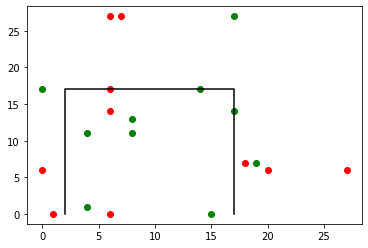

In [30]:
#Map of letters to numbers
alph = list('abcdefghijklmnopqrstuvwxyz')
a_map = {}
for i in range(26):
  a_map[alph[i]] = i
a_map[' '] = 27
a_map['-'] = 27

def get_chars(lam, num=7):
  return np.array(list(df[df['Race'].apply(lam)]['Name'].agg('sum').lower()))

elf_chars = get_chars(lambda c: 'Elf' in c or 'elf' in c)
orc_chars = get_chars(lambda c: 'Orc' in c)[:-1]

#Powerset and convert to ints
def split2(lst):
  rv = []
  for i in range(len(lst)-1):
    rv.append(lst[i:i+2])
  return rv

elf_pairs = split2(elf_chars)
orc_pairs = split2(orc_chars)

prs, cts = np.unique(elf_pairs, return_counts = True, axis=0)
elf_pairs = prs[cts.argsort()][-10:]

prs, cts = np.unique(orc_pairs, return_counts = True, axis=0)
orc_pairs = prs[cts.argsort()][-10:]

print(f"Most common elvish character pairings:\n {elf_pairs}")
print(f"Most common orcish character pairings:\n {orc_pairs}")

def ltn(lst):
  ptn = lambda x: [a_map[x[0]], a_map[x[1]]]
  return np.array([ptn(x) for x in lst])

elf_pts = ltn(elf_pairs)
orc_pts = ltn(orc_pairs)

plt.scatter(elf_pts.T[0], elf_pts.T[1], c='green')
plt.scatter(orc_pts.T[0], orc_pts.T[1], c='red')
plt.plot([2,2,17,17],[0,17,17,0], c='black')

#Higher Dimensions
Now you can imagine that any point within the black box above is most likely an Elvish name. Likewise, any point outside the box is probably an Orcish name. This is the same logic we will use in 26 dimensions, where we have one for each character in the alphabet. Lets begin by mapping each name to a 26 degree vector. This vector is populated using the character counts in each name. So if there are 2 As in any name, the first entry will be 2. Likewise, if there is 1 G, the 6th entry will be 1.

In [31]:
alph = list('abcdefghijklmnopqrstuvwxyz')
a_map = {}
for i in range(26):
  a_map[alph[i]] = i

#Character count vector
def char_vec(s):
  vec = [0] * 26
  chars, counts = np.unique(list(s.lower()), return_counts=True)  
  for i in range(len(chars)):
    c = chars[i]
    if c in a_map.keys():
      vec[a_map[c]] = counts[i]
  return vec

vecs = []
for x in df['Name']:
  vecs.append(char_vec(x))
vecs = np.array(vecs) #All vectors for character names (same order as the dataframe)

df['Name'][0], vecs[0]

('Aragorn II',
 array([2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0]))

#How Everything Works
To compute the distances between vectors we will use euclidean distance. That is for two n length vectors Va = [va0, va1, ... Van] and Vb = [vb0, vb1, ..., vbn] the distance $d = \sqrt[2]{(va0 - vb0)^2 + (va1 - vb1)^2 + ... + (van - vbn)^2}$

To find the closest name in lord of the rings, we will use a simplified version of the K-Nearest-Neighbors algorithm. If you are interested, here is a link that explains more: https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761.

For everyone else, it will basically sort the distance of each name in ascending order. Then the position of our closest match is the first one in the list.

In [32]:
#Euclidean Distance between each vector
def dist(v):
  return np.sqrt(np.sum((vecs - v)**2, axis=1))

#K Nearest Neighbor (K is the length of the list in this case)
def KNN(s):
  v = np.array(char_vec(s))
  dists = dist(v)
  return np.argsort(dists)

#Matches a name to its closest information
def match_name(name):
  neighbors = KNN(name)
  race = df['Race'][neighbors[0]] #Race of closest name
  eth = next(item for item in df['Ethnicity'][neighbors] if item is not None) #Race of closest name with a listed ethnicity
  rel = df['Name'][neighbors[0]] #
  locs = df['Homes'][neighbors].to_numpy()
  locs = locs[locs != None][0:10]
  homes, counts = np.unique(np.concatenate(locs), return_counts=True)
  home = homes[counts.argsort()[-1]]
  return(eth, race, home, rel)

#Print the result using HTML so it looks nice
def display_results(name, res):
  disp = f"""
    <h1>{name}'s Results</h1>
    <h4>Closest Ethnicity: {res[0]}</h4>
    <h4>Closest Race: {res[1]}</h4>
    <h4>Possible Home: {res[2]}</h4>
    <h4>Closest Relative: {res[3]}</h4>
  """
  display(IPython.display.HTML(disp))

#Run the above methods in the right order
def run(name):
  display_results(name, match_name(name))

Now lets test our method using my name, the common elf characters, and the common orc characters. If all goes well, the elvish and orcish characters should return the name and race of an elf and orc respectively.

In [33]:
run("Owen Knott")
#Run the string of common elf character pairs
elf = "" 
for x in np.unique(np.concatenate(elf_pairs)):
  elf += x 
run(elf)
run("ugkluz")

The results are good but some of them do not make sense. Some ethnicities and names or races do not line up since not all ethnicities are listed. Similarly, some of the places of residence do not make sense with the rest of the data. Individually, these values are the closest that are provided to each passed name. However, since there is missing data, not all values are directly associated. This is just the nature of using untidied data.

#Class Results

In [34]:
r_html = open('ENG375_Creative_Proj/Class_Roster.rtf').read()
rbs = bs(r_html)
rost = rbs.find_all("a",'roster_user_name')

for elt in rost:
  name = elt.text
  try:
    name = name[:name.index('(')]
  except:
    pass
  run(name)
  